In 2013 I made one of the few new years resolutions I've ever made and the only one I've ever stuck to, to write a daily diary. Five years later, it's approaching 2000 entries and quarter of a million words. This January I decided to do a little playing around and look at some of the patterns in my own very personal data set.

# Load and Clean Data 

In [1]:
# Get some useful python library stuff
import re
import string
import datetime as dt
from collections import deque, defaultdict

# Get some analysis packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Get some iPython jazz
from IPython.display import display

# Get some modely things
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Abracadabra
%matplotlib inline
plt.style.use('ggplot')

In [2]:
# Load diary
with open('diary-2013-2017.txt') as f:
    lines = list(f)

# Remove empty lines
full_lines = [ll for ll in lines if ll.strip() != '-']

# Remove punctuation and shizzle, and the heading
strip_pattern = re.compile('[^\w %s]' % re.escape(string.punctuation))
clean_lines = [strip_pattern.sub('', ll) for ll in full_lines[2:-1]]

In [3]:
# Some tidy-ups, because my typing is inaccurate and punctuation is messy
letters_pattern = re.compile('[a-zA-Z]+')
weekday_spelling_corrections = {
    'Thus': 'Thu',
    'Son': 'Sun',
    'Thur': 'Thu',
    'Fi': 'Fri',
}

# Iterate through lines, parsing them into a list of entries
entries = []
queue = deque(clean_lines)
while queue:
    line = queue.popleft()
    
    if (line.startswith('- ')):
        year = int(line[2:])
    elif (line.startswith('  - ')):
        month = line[4:]
    elif (line.startswith('    - ')):
        weekday, day = line[6:].split()
        day = int(letters_pattern.sub('', day))
        if weekday in weekday_spelling_corrections:
            weekday = weekday_spelling_corrections[weekday]
    elif (line.startswith('      - ')):
        text = line[8:]
        
        entries.append({
            'year': year,
            'month': month,
            'day': day,
            'weekday': weekday,
            'text': text
        })

diary = pd.DataFrame(entries)[['year', 'month', 'day', 'weekday', 'text']]

In [4]:
# Let's have a look
display(diary.tail(5))

,year,month,day,weekday,text
1823,2017,December,26,Tue,"Boxing Day. Katy was back to work, but I had t..."
1824,2017,December,27,Wed,Back to work. Took care of some on call bits a...
1825,2017,December,28,Thu,Spent the whole day refactoring the brand conf...
1826,2017,December,29,Fri,Another day of refactoring. Most of it is done...
1827,2017,December,30,Sat,Spent today with Ashley and his wife Ellie who...


In [5]:
# Check that I got all those mis-spellings
print(str(len(set(diary['year']))) + ' years: ' + str(set(diary['year'])))
print(str(len(set(diary['month']))) + ' months: ' + str(set(diary['month'])))
print(str(len(set(diary['day']))) + ' days: ' + str(set(diary['day'])))
print(str(len(set(diary['weekday']))) + ' weekdays: ' + str(set(diary['weekday'])))

5 years: {2016, 2017, 2013, 2014, 2015}
12 months: {'September', 'August', 'March', 'July', 'January', 'February', 'November', 'December', 'October', 'May', 'April', 'June'}
31 days: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}
7 weekdays: {'Mon', 'Tue', 'Wed', 'Sat', 'Sun', 'Fri', 'Thu'}


In [6]:
# Add a date column
months = [
    'January',
    'February',
    'March',
    'April',
    'May',
    'June',
    'July',
    'August',
    'September',
    'October',
    'November',
    'December',
]
diary['date'] = diary.apply(lambda row: dt.date(row['year'], 1 + months.index(row['month']), row['day']), axis=1)

# Entry Length Analysis

Let's start by looking simply at the lengh of the entries. First, the longest and shortest entries.

In [7]:
# Add a word count column
diary['word_count'] = diary.apply(lambda row: len(row['text'].split()), axis=1)

# When was the longest entry
print('Max word count: ' + str(max(diary['word_count'])) + " on " + str(diary['date'][np.argmax(diary['word_count'])]))

# When was the shortest entry
print('Min word count: ' + str(min(diary['word_count'])) + " on " + str(diary['date'][np.argmin(diary['word_count'])]) + ' It reads: ' + diary['text'][np.argmin(diary['word_count'])])

# Total and average
print('The whole diary has ' + str(diary['word_count'].sum()) + ' words (so far).')
print('The average entry has ' + str(int(diary['word_count'].sum() / len(diary))) + ' words.')

Max word count: 837 on 2015-02-11
Min word count: 9 on 2014-03-12 It reads: Ill. Stayed at home in bed and watched tv.
The whole diary has 243100 words (so far).
The average entry has 132 words.


That day with the longest entry is during our honeymoon, our first full day in Big Sur. So no surprises there.

Next let's look at hour length varies over time.

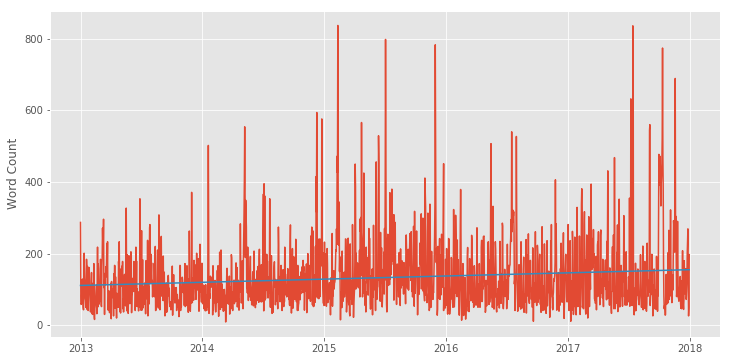

In [8]:
# Plot word count against date
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(diary['date'], diary['word_count'])
ax.set_ylabel('Word Count')

# Add a naive linear trendline
idx = range(len(diary))
z = np.polyfit(idx, diary['word_count'], 1)
ax.plot(diary['date'], z[1] + idx * z[0])

plt.show()

Extended periods of longer entries correspond to trips and holidays, e.g. February 2015 (honeymoon), July 2016 (first visit home after emigrating) and October 2017 (Tibet).

Also, there's a slow increase in the average entry length over time, as I've got quicker and more formulaic in my writing.

Let's have a look at the distribution of entry lengths.

/usr/local/lib/python3.4/dist-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


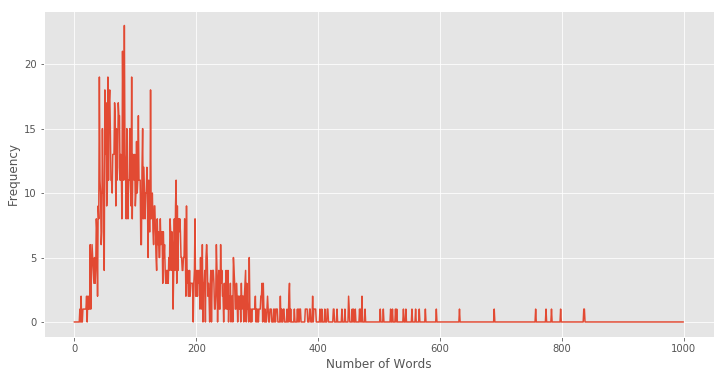

In [9]:
# Build a histogram of word counts
length_counts = np.zeros(1000)
for count in diary['word_count']:
    length_counts[count] += 1

# Plot word count histogram
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(length_counts)
ax.set_xlabel("Number of Words")
ax.set_ylabel("Frequency")
fig.show()

Looks pretty gamma-ish.

# Words Analysis

Now let's have a look at what words I actually use. First lets clean them up.

In [10]:
# Add a column for cleaned words
def tokenize_words(text):
    non_alphanum_pattern = re.compile('[^\w ]')
    return non_alphanum_pattern.sub('', text.lower()).split()

diary['words'] = diary.apply(lambda row: tokenize_words(row['text']), axis=1)

In [11]:
# Get all the words
all_words = [word for words in list(diary['words']) for word in words]

Starting simple, let's see what words I use most.

In [12]:
# Count occurences of each word
counts = defaultdict(lambda: 0)
for word in all_words:
    counts[word] += 1

word_counts = pd.DataFrame.from_records(list(counts.items()))
word_counts.columns = ['word', 'count']
word_counts = word_counts.sort(columns='count', ascending=False)

display(word_counts.head(20))

,word,count
13269,the,13696
12350,and,11982
12860,a,7252
4722,to,7211
3268,i,6182
12786,in,4515
1120,of,4185
1950,we,3601
2302,was,3501
6507,for,2935


Mostly uninteresting little filler words. Let's exclude the boring stuff. I've grabbed a stop word list of some random website. Let's try again without those.

In [13]:
# Load stop words
stopwords = []
with open('stopword.txt') as f:
    for line in f:
        stopwords.append(line[:-1]) # Why is there a trailing \n?
        
word_counts_without_stopwords = word_counts[word_counts.apply(lambda row: row['word'] not in stopwords, axis=1)]

display(word_counts_without_stopwords.head(20))

,word,count
11631,went,1735
5935,evening,1375
7523,katy,1230
6137,back,1061
2126,day,1023
13882,morning,950
5621,got,908
10729,work,776
7570,home,700
3837,afternoon,697


These seem to be mostly words which describe when and where things happened, which I must use pretty much every day.

How about what names I use? This is going to be harder because there's no easy or consistent way to detect which words are names, especially because I'm not very good at consistently capitalising them. So, somewhat crudely, I'm just going to go grab a list of names off the internet and then ammend it as required.

In [14]:
# Load a list of names I pulled off the internet
names = []
with open('boys-names.txt') as f:
    for line in f:
        names.append(line[:-1].lower().strip())
with open('girls-names.txt') as f:
    for line in f:
        names.append(line[:-1].lower().strip())
names = set(names)

# Add some crucial ones that are missing
names.add("katy")
names.add("briony")
names.add("mummy")
names.add("daddy")
names.add("niki")
names.add("konrad")
names.add("tom")
names.add("stacey")
names.add("jonno")
names.add("fran")
names.add("bodz")
names.add("kat")
names.add("lewi")
names.add("fi")
names.add("david")
names.add("rob")
names.add("noore")
names.add("milly")
names.add("pete")
names.add("keith")
names.add("alastair")
names.add("crispin")
names.add("eddy")
names.add("clare")
names.add("nick")
names.add("tim")
names.add("jens")
names.add("jc")

# Remove some words that are more usually not names of people
names.remove("river")
names.remove("sky")
names.remove("miles")
names.remove("london")
names.remove("grey")
names.remove("ridge")
names.remove("francisco")
names.remove("austin")
names.remove("antonio")
names.remove("crew")
names.remove("case")
names.remove("hope")
names.remove("summer")
names.remove("marina")
names.remove("henley")
names.remove("king")
names.remove("major")
names.remove("rose")
names.remove("drew")
names.remove("winter")
names.remove("journey")
names.remove("rocky")
names.remove("chance")
names.remove("jesus")
names.remove("america")

# That was a shitty list
 
name_counts = word_counts[word_counts['word'].isin(names)]

display(name_counts.head(50))

,word,count
7523,katy,1230
3344,emily,231
9489,will,156
14334,jonno,140
1515,chris,133
12970,niki,132
7648,stacey,128
12024,max,124
13337,tom,106
11717,henry,103


Unsurprisingly, the name of my wife is at the top by a long way. "Will" is up there principally because of his roll as an auxiliary verb, but I didn't exclude this because I do know a couple of Wills who are mentioned quite frequently. "Emily" and "Chris" are/were both housemates for lengthy periods. The other highest-scorers are rowing buddies who I spent most of 2013-2014 training with. Then there's a load of close friends, family and sailing teammates.

# Characteristic Features

Now for something a little more sophsiticated. Let's look for characteristic features of particular times. We can do this by training a single softmax classification model to predict the time using word count features.

In [15]:
# Join the words together again, to put them in expected format
clean_content = [" ".join(words) for words in diary['words']]

# Generate count feature matrix
count_vectorizer = CountVectorizer(
    max_df=0.95,
    min_df=2,
    stop_words='english'
)
X = count_vectorizer.fit_transform(clean_content)
feature_names = count_vectorizer.get_feature_names()

In [16]:
# I copied this from the internets
def display_top_words_for_class(feature_names, classifier, idx, n=20):
    word_weights = pd.DataFrame.from_records(list(zip(feature_names, classifier.coef_[idx])))
    word_weights.columns = ['word', 'weight']
    word_weights = word_weights.sort(columns='weight', ascending=False)
    display(word_weights.head(n))

In [17]:
def train_model_and_display_features(X, y, labels):
    classifier = LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=1000,
        random_state=0,
    ).fit(X, y)
    
    for idx in range(len(labels)):
        print("Top features for " + str(labels[idx]))
        display_top_words_for_class(feature_names, classifier, idx)

In [18]:
# Predict year
years = [2013, 2014, 2015, 2016, 2017]
y_year = [years.index(year) for year in diary['year']]
train_model_and_display_features(X, y_year, years)


Top features for 2013


,word,weight
2995,heartbeat,0.914226
4513,outing,0.864666
4752,piano,0.815819
5549,rowing,0.752729
6424,supervising,0.699441
7225,wind,0.659244
5048,proposals,0.582142
1550,cppf,0.575382
681,bit,0.563273
5366,report,0.543456


Top features for 2014


,word,weight
4620,particle,1.417174
3519,katys,1.233377
6599,tesco,1.207133
7167,weights,0.822310
3518,katy,0.759213
747,book,0.749417
3669,learning,0.737472
4513,outing,0.696585
7108,want,0.657040
2734,gibbs,0.581226


Top features for 2015


,word,weight
1684,data,0.904419
5248,recipe,0.861969
4681,peer39,0.800558
5190,ran,0.790465
4593,paper,0.774023
5074,ptp,0.770993
6599,tesco,0.755976
3740,linear,0.741236
1474,cooked,0.661015
5075,ptps,0.649442


Top features for 2016


,word,weight
3532,keyword,1.429509
3533,keywords,1.156588
1756,demographic,0.875390
5368,reporting,0.767734
3494,jumpshot,0.761630
4141,modeling,0.701136
2289,experimental,0.688384
4014,meetings,0.675819
1119,chatted,0.674433
2186,enterprise,0.670194


Top features for 2017


,word,weight
657,bidder,1.280917
871,budgeter,1.277751
1455,controller,0.956172
2288,experiment,0.805854
5728,search,0.760220
1407,config,0.752299
797,brand,0.752008
659,bidding,0.750078
1453,control,0.741569
1774,deploy,0.685593


This is kinda fascinating. It's picked out lots of words related to what I was doing at work. 2013 and 2014 have lots of rowing words and stuff from my PhD. Katy appears and features prominantly in 2014 when we were dating. 2015 has stuff from my time as a consultant as Tesco, and from my first project at Quantcast. It also has 'recipe', which is nice as this was the year that we resolved to cook a new recipe each week. Lots of Quantcast words in 2016, plus 'cycle' appears - this was when I got my bike. In 2017 we did lots of hiking and went to China, both of which feature amongst lots of control system words.

In [19]:
# Predict month
y_month = [months.index(month) for month in diary['month']]
train_model_and_display_features(X, y_month, months)

Top features for January


,word,weight
658,bidders,0.951503
5048,proposals,0.850039
3264,inference_utils,0.778048
4476,optimal,0.772390
4646,patent,0.750243
5953,skiing,0.727797
6532,targeting,0.668606
3987,mcmc,0.667249
5047,proposal,0.652573
5041,proofreading,0.620380


Top features for February


,word,weight
656,bid,0.958486
797,brand,0.904944
2273,existing,0.755121
6013,smon,0.750560
521,backward,0.703067
657,bidder,0.696173
2558,forecasting,0.653688
1203,circuits,0.647698
3775,loading,0.598398
5222,reading,0.596506


Top features for March


,word,weight
6705,tired,0.604976
7304,writeup,0.600779
3839,lovely,0.594408
1268,cluster,0.588806
7225,wind,0.586861
6876,tv,0.581881
3958,match,0.562375
657,bidder,0.561259
4727,pgibbs,0.547162
6604,testing,0.543174


Top features for April


,word,weight
960,camp,0.878911
476,aurora,0.714004
6278,stochastic,0.691920
2874,grumpy,0.688452
3402,james,0.687502
5329,relaxed,0.676289
5165,racing,0.653978
3414,jc,0.648947
6424,supervising,0.594553
4416,odd,0.593589


Top features for May


,word,weight
871,budgeter,1.113601
5458,rich,0.821378
6602,test,0.744167
6428,supf,0.730947
6225,starts,0.715836
6175,sql,0.705919
6569,tedious,0.690929
6095,spaced,0.668871
2212,error,0.646459
4998,problem,0.643481


Top features for June


,word,weight
871,budgeter,0.865668
4849,poem,0.757969
3029,henley,0.706272
4513,outing,0.686750
7309,wrote,0.684607
5929,simulations,0.672794
955,cambridge,0.663700
6898,umbel,0.638886
7277,worked,0.603609
7160,weekend,0.587214


Top features for July


,word,weight
889,bumps,1.179075
1455,controller,0.989892
992,car,0.700848
2995,heartbeat,0.692069
3832,lots,0.668969
3739,line,0.659274
1088,changed,0.657959
4800,place,0.621363
4593,paper,0.620086
2136,emba,0.607094


Top features for August


,word,weight
676,birthday,0.899453
1455,controller,0.769153
5715,scull,0.737935
1777,deployment,0.719827
3494,jumpshot,0.688592
5026,progress,0.671750
622,beer,0.664011
3524,keith,0.662501
6659,throttle,0.624825
6495,systems,0.613216


Top features for September


,word,weight
2620,frequency,0.818621
6316,stretches,0.710726
4755,pick,0.698331
2674,galavant,0.691059
4014,meetings,0.642281
5733,season,0.638387
6494,systematic,0.637445
7264,wonderful,0.633414
653,better,0.632575
3960,matching,0.618110


Top features for October


,word,weight
6627,thesis,1.057694
2517,flow,0.910654
5368,reporting,0.792513
7166,weight,0.781143
1550,cppf,0.718607
297,analysis,0.702922
200,admin,0.688526
2699,gave,0.677341
505,awkward,0.603898
4623,partied,0.601086


Top features for November


,word,weight
4681,peer39,1.340271
5206,rate,1.117461
5368,reporting,1.084449
5691,scoring,1.005565
7008,variable,0.893885
4926,pppf,0.884861
1684,data,0.785330
2685,gaps,0.681814
6190,stacey,0.661547
3854,lunch,0.657709


Top features for December


,word,weight
1186,christmas,1.555379
4585,panel,0.917745
7090,wais,0.805642
3336,interviewing,0.783654
1756,demographic,0.743146
1099,chapter,0.725379
3518,katy,0.687818
3538,kids,0.644755
3977,max,0.597511
3302,instead,0.545826


These are less interesting, perhaps unsurprisingly. There's a number of things related to short projects and tv shows that I binge watched. We have 'skiing' in January, 'henley' in June and 'christmas' in December.

In [20]:
# Predict weekday
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
y = [weekdays.index(weekday) for weekday in diary['weekday']]
train_model_and_display_features(X, y, weekdays)

Top features for Mon


,word,weight
7167,weights,1.490861
3333,interview,0.735743
4354,noriega,0.720026
955,cambridge,0.689700
1186,christmas,0.637346
7308,wrong,0.631517
5913,silicon,0.589620
4901,postdoc,0.586385
2624,friday,0.585102
6140,spirits,0.578626


Top features for Tue


,word,weight
6173,sprint,1.336251
5435,review,1.278864
6181,squash,0.852891
7150,weather,0.725618
4432,ok,0.712032
2933,handling,0.680318
6424,supervising,0.670864
7278,working,0.640624
4014,meetings,0.620416
4363,nose,0.618095


Top features for Wed


,word,weight
3885,mainly,0.854112
4013,meeting,0.799003
4811,planning,0.794192
1495,core,0.791127
4613,parkside,0.773731
6604,testing,0.750251
3444,job,0.656426
236,agreed,0.641366
6569,tedious,0.630573
7167,weights,0.600603


Top features for Thu


,word,weight
1203,circuits,0.841460
7309,wrote,0.766063
5763,seminar,0.727718
6993,ut2,0.701244
5446,rewrite,0.625362
6424,supervising,0.580453
797,brand,0.568307
1294,coding,0.568062
4913,potential,0.563988
3775,loading,0.551394


Top features for Fri


,word,weight
622,beer,0.994473
2949,happy,0.980755
3157,hung,0.782620
3132,hour,0.744344
4971,pretty,0.711157
6236,stay,0.665581
2018,drink,0.640564
6880,twilight,0.597820
425,ashley,0.575347
6773,trailer,0.566418


Top features for Sat


,word,weight
5967,slept,0.749200
5943,sitting,0.744147
5741,second,0.740474
6414,sunny,0.739217
3710,lie,0.676330
3414,jc,0.675458
5864,shopping,0.612265
2969,having,0.586053
1648,cycle,0.564682
5180,raining,0.539629


Top features for Sun


,word,weight
2361,family,1.497113
858,brunch,1.174661
3658,lazy,0.920591
7326,yesterday,0.662708
7127,washing,0.648621
7133,watched,0.636248
4123,miss,0.602897
7115,warm,0.576267
7160,weekend,0.567462
500,away,0.564935


I love this. I wonder why 'friday' appears on Monday... You can see that Chris and I used to play squash every Tuesday. You can see sprint review meetings have consistently been on Tuesdays, and planning on Wednesday. (Could this be why 'tedious' is also in there?) Rowing 'circuits' were always on Thursday. It's amusing to see 'beer', 'happy', 'hour' and 'drink' all at the top of the list of Friday. The weekend stands out most of all. You can see how I've spent them: 'rowing' and 'cycling' (and 'shopping', apparently), and there's 'slept' and 'lie' hinting at late starts. Sunday is clearly my day of rest, with 'lazy', 'brunch', 'read' and 'watched'. And it's also the day of 'family' 'dinner'.

# Clustering

Finally, let's train a topic model to see what clusters we can teeze out. Time for a spot of LDA.

In [21]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=20,
    learning_method='batch',
    max_iter=10,
    learning_offset=50.0,
    random_state=0).fit(X)

In [22]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

print_top_words(lda, feature_names, 20)

Topic #0: evening work day spent today morning katy good really tesco time linear working started got data paper learning afternoon trying
Topic #1: went got katy morning niki dinner konrad evening bit day time did good boat afternoon played arrived granny came today
Topic #2: went katy drove beach way morning little day walked time sun lunch home dinner got great evening valley took afternoon
Topic #3: went katy evening work good day morning really got time quite dinner home did afternoon bit felt spent just today
Topic #4: katy river went chat hotel water just came walked lake day welcome lunch little night time stopped way pleasant late
Topic #5: work bidder evening changes today experimental went spent code budgeter review morning brand deployed afternoon working day experiment katy keyword
Topic #6: evening day really spent morning meetings went started worked afternoon work bit katy planning sprint home working good new finished
Topic #7: particle flow evening work got progress w

That's... a bit disappointing. There's a lot of common words appearing in many topics. Maybe it needs some more tuning. Could also try something like word2vec instead, but I'm out of time for now.